In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-11-23 17:25:35.872113: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-11-23 17:25:35.872144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 4

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2025-11-23 17:25:47.414261: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-11-23 17:25:47.414324: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2025-11-23 17:25:47.414369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mat-ThinkPad-E16-Gen-1): /proc/driver/nvidia/version does not exist
2025-11-23 17:25:47.414902: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 17:25:47.430545: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency:

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.5296 - accuracy: 0.1797
Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 0s 3ms/step - loss: 1.4329 - accuracy: 0.2181 - val_loss: 1.3221 - val_accuracy: 0.3342
Epoch 2/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.3097 - accuracy: 0.3594
Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.3162 - accuracy: 0.3337 - val_loss: 1.2658 - val_accuracy: 0.3668
Epoch 3/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.2756 - accuracy: 0.3828
Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.2686 - accuracy: 0.3696 - val_loss: 1.2227 - val_accuracy: 0.3876
Epoch 4/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.2422 - accura

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 2ms/step - loss: 0.1970 - accuracy: 0.9708


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.7431111e-01 2.5235591e-02 1.8394571e-04 2.6935784e-04]
0


# Confusion matrix

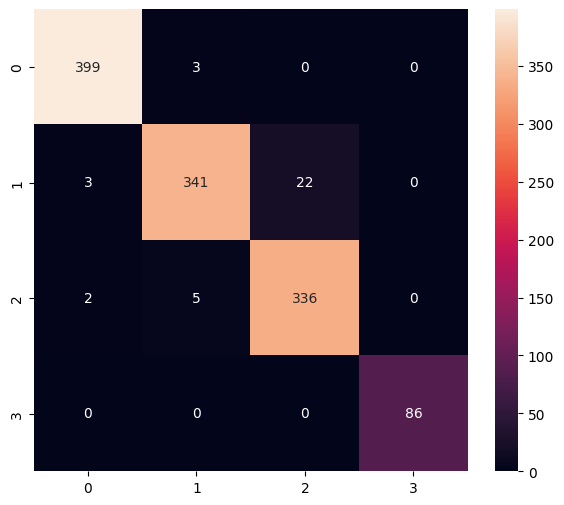

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       402
           1       0.98      0.93      0.95       366
           2       0.94      0.98      0.96       343
           3       1.00      1.00      1.00        86

    accuracy                           0.97      1197
   macro avg       0.98      0.98      0.98      1197
weighted avg       0.97      0.97      0.97      1197



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2025-11-23 17:27:11.045404: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpv2uvm9kq/assets


2025-11-23 17:27:11.303378: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-11-23 17:27:11.303510: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2025-11-23 17:27:11.304509: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:816] Optimization results for grappler item: graph_to_optimize
2025-11-23 17:27:11.304519: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: function_optimizer did nothing. time = 0.007ms.
2025-11-23 17:27:11.304521: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: function_optimizer did nothing. time = 0.001ms.
2025-11-23 17:27:11.321002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:313] Ignored output_format.
2025-11-23 17:27:11.321025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored drop_control_dependency.
2025-11-23 17:27:11.326380:

6256

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 85 µs, sys: 13 µs, total: 98 µs
Wall time: 108 µs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.7431111e-01 2.5235591e-02 1.8394589e-04 2.6935784e-04]
0
